# Business Impact of Discoount
We conduct a brief analysis of the strategy that the SME division head proposed. This is not necessarily the optimal strategy.<br>
The SME division head proposed that we give a 20% discount to high propensity-to-churn customers. We can assume to start that everyone who is offered a discount will accept it.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## General Workflow
Our task is to calculate the forecast revenue of the set of customers:
1. When no discount is offered, and
2. Whena discount is offered based on some probability cut-off to decide who should receive a discount 20%
... and therefore decide where the cut-off should be set so as to maximise revenue.

Do the following:


### Load the data 
- Load the pickle file of out-of-sample predictions from the best model
- Sort the predictions by predicted probability of churn in descending order (ie, highest predicted probability of churn customers first)

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# load data
predictions = pd.read_pickle('/content/drive/MyDrive/Forage/BCG-customer-churn/processed_data/xgb_outOfSamplePredictions.pkl')


In [4]:
predictions.head()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,pow_max,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_sdd,channel_usi,origin_ewx,origin_kam,origin_ldk,origin_lxi,origin_usa,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_sfi,activity_wxe,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,y_test_pred,y_test
5871,5.472865,5.225325,4.229528,3.270241,0.0,1.811240,0.145711,0.000000,44.311378,1,1.522705,27.14,27.14,2,168.10,13.2,6,69.0,2.0,69.0,9.0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0.150471,0.000000,0.000000,44.400265,0.000000,0.000000,44.550736,0.000000,0.000000,0.027380,0
6997,5.268058,0.000000,4.067220,4.152069,0.0,2.115976,0.110955,0.095842,40.606701,0,3.019723,-8.31,-8.31,1,1124.18,45.0,4,37.0,10.0,37.0,1.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.121060,0.100728,0.070521,40.579547,24.347725,16.231816,40.700608,24.448453,16.302337,0.072887,0
1516,4.218850,0.000000,3.333850,3.131567,0.0,2.120640,0.112860,0.096521,40.606701,0,2.215770,20.17,20.17,1,138.43,19.0,3,34.0,6.0,17.0,5.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.119572,0.099106,0.069847,40.647427,24.388455,16.258971,40.767000,24.487562,16.328818,0.114987,0
11616,4.302374,0.000000,0.000000,3.474324,0.0,1.287130,0.144149,0.000000,44.311378,0,0.000000,25.72,25.72,1,279.61,12.5,5,57.0,2.0,57.0,9.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.147999,0.007124,0.000000,44.385450,0.000000,0.000000,44.533449,0.007124,0.000000,0.140574,0
2532,5.511454,0.000000,4.743518,3.668502,0.0,1.985382,0.116509,0.101397,40.606701,0,2.979485,12.04,12.04,1,551.99,36.0,4,38.0,9.0,38.0,2.0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0.125629,0.105437,0.075251,40.593123,24.355871,16.237247,40.718752,24.461308,16.312498,0.088995,0


### Calculate a baseline revenue estimate (no intervention)
Calculate a baseline estimate of the electricity revenue for every customer for the next twelve months based on the forecast consumption and forecast price and actual churn ouotcomoe. Call this `basecase_revenue`


- For customers who end up churning, we should reduce our forecast revenue calculation by 91.9% to account for the customers churn some time between January 2016 and the start of March 2016. (Not knowing when they churn, a reasonable assumption for the lost revenue is the average of 100%, corresponding to churn on 1 January 2016, and 83.9%, corresponding to churn at the end of February, or 59 days into a 365 day year).Call this new variable basecase_revenue_after_churn, ie basecase_revenue_after_churn = basecase_revenue * (1- 0.919 * churn)

In [5]:
# Electricity revenue for each customer consists of energy consumption (amount * price) and the meter rent
# The power price may also play a role, but we will ignore it for now 
# Note that we need to reverse the log10-trransformation from the data cleaning step
predictions['basecase_revenue'] = \
(np.power(10, predictions['forecast_cons_12m'])+1) * predictions['forecast_price_energy_p1'] + \
np.power(10, predictions['forecast_meter_rent_12m']+1)

In [6]:
# taking churn into account
predictions['basecase_revenue_after_churn'] = predictions['basecase_revenue'] * (1 - 0.919 * predictions['y_test'])

## Calculate the estimated benefits and costs of intervention
Now, pick a cut-off probability (eg, 0.5) so that:
 - Customers with a higher churn probability than cut-off get a discount, and
 - Customers below the churn-probability get a discount.
From this, calculate the revenue of the intervention scenario of this this scenario assuming:
 - All customers who are offered a discount accept it
 - Customers who do receive a discount are assumed not to churn in the next twelve months (ie churn probability = 0), and therefore the retained revenue is 0.8 * basecase_revenue, being (1 - discount_frraction) * basecase_revenue
 - Customers who do not receive a discount are assumed to churn based on the observed dependent variable (ie, a 1 or 0 for whether they actually churned or not)
 
Now, map out the revenue delta as a function of the cut-off probability in a graph

What cut-off probability approximately optimize the revenue outcome?

Assume for these calculations that the customer does not cinsume more or less electricity because the price changes. (In practice, we would expect that if the customer's cost goes down then their consumption might increase.)

We will see two counterbalancing effects at play:
- For true positive we will see revenue retention vs the no-discount scenario
- For false positive we will see reduce revenue from giving them a discount when they wouldn't in fact churn

(False negative represent an opportunity cost but not an actual cost differrence between the two scenarios)

The optimal cut-off point will balance the benefits from true positives against the costs of false positives.<br>
Our task is to approximately fimd the optimal cut-off point. We many need to make additional assumptions. If we feel the assumptions above aren't justified and that others are better than we should modify our assumptions.

In [7]:
def get_rev_delta(pred: pd.DataFrame, cutoff: float = 0.5, discount: float = 0.2) -> float:
    '''
    Get the delta of revenue for offering discount for all customers with predicted churn risk >= cutoff
    '''
    pred['discount_revenue'] = pred['basecase_revenue_after_churn']
    # Churn predicted => discount is given => customer stays for full year, independent of whether the prediction
    # (false positive, 'free'/unnecessary discount given) or correct
    pred.loc[pred['y_test_pred'] >= cutoff, 'discount_revenue'] = pred['basecase_revenue'] * (1 - discount)
    # save tthe revenue delta for each custtomer in a separate column
    pred['revenue_delta'] = pred['discount_revenue'] - pred['basecase_revenue_after_churn']
    return pred['revenue_delta'].sum()

In [8]:
# Generate a list of possible cutoffs and the corresponding overall revenue deltas
rev_deltas = pd.Series({cutoff: get_rev_delta(predictions, cutoff = cutoff) for cutoff in np.arange(0, 1, 0.01)})

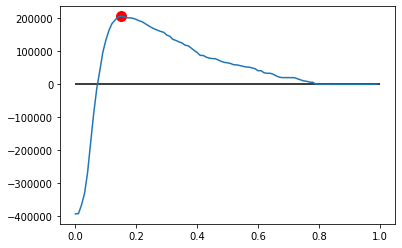

Maximum benefit at cutoff 0.15 with revenue delta of $206,846.04


In [9]:
def plot_tradeoff(rev_deltas: pd.Series):
    # Plot the revenue deltas
    rev_deltas.plot()
    # mark optimal point
    max_pred = rev_deltas.idxmax()
    plt.scatter(max_pred, rev_deltas.loc[max_pred], s = 100, c = 'red')
    # Reference line for break-even
    plt.hlines(0, 0, 1)
    plt.show()
    print(f'Maximum benefit at cutoff {max_pred} with revenue delta of ${rev_deltas.loc[max_pred]:,.2f}')

plot_tradeoff(rev_deltas)

## Optional Extra: How to select the cut-off?
Above, we decide who to offer the discount to based on the probability cut-off.

In this the optimal strategy?
- For instance, we might be offering discounts to customers who are not very profitable, thus worsening our overall margins substantially. For example, if offering a discount makes the customer unprofitable on a net margin basis then we might want to let them churn rather than save them.
- Even if we only consider revenue, this strategy might not be optimal from a revenue viewpoint. For instance, we can calculate the expected revenue impact of our strategy and priorities customers for discounts that have a high expected revenue impact. (This means that the probability of churn might be high but they also might be valuable customers).

A general principle here is that we can afford to spend moe on retaining high-value customers because the costs of losing them are higher.

A very common mistake in business applications of churn is to focus on the churn probability whilst forgetting the value impact (to greater or lesswe extents). We have seen many cases where our clients spend as much as effort on retainingupprofitable customers as they do on retaining highly profitable customers.

In [10]:
def get_rev_delta_high_value(pred: pd.DataFrame, cutoff: float = 0.5, discount: float = 0.2, min_rev: float = 500) -> float:
    '''
    Get the delta of revenues for ooffering discount for all customers with predicted churn risk >= cutoff and revenue
    '''
    pred['discount_revenue'] = pred['basecase_revenue_after_churn']
    # churn predicted => discount is given for high-value customers => customer stays for full year, independent
    pred.loc[(pred['y_test_pred'] >= cutoff)&(pred['basecase_revenue'] > min_rev), 'discount_revenue'] = pred['basecase_revenue'] * (1 - discount)
    # save the revenue delta for each customer in a separate column
    pred['revenue_delta'] = pred['discount_revenue'] - pred['basecase_revenue_after_churn']
    return pred['revenue_delta'].sum()

In [11]:
# generate a list of possible cutoffs and the corresponding overall revenue deltas
rev_deltas_high_value = pd.Series({cutoff: get_rev_delta_high_value(predictions, cutoff = cutoff) for cutoff in np.arange(0, 1, 0.01)})


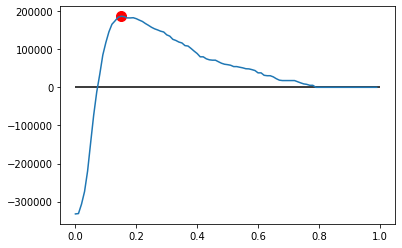

Maximum benefit at cutoff 0.15 with revenue delta of $186,551.34


In [12]:
# generate a list of possible cutoffs and the corresponding overall revenue deltas
plot_tradeoff(rev_deltas_high_value)

> Note: In this case, it doesn't make sense to prioritize large-revenue customers, since the overall revenue delta is much lower than when targeting everyone. However, this is only the case here since the intervention doesn't depend on the number of customers (simply adjusting prices). The interventions usually go beyond simply adjusting prices to prevent churn. There may be the option of intensifying the customer relation, adding key account managers, or other interventions that do incur costs depending on how many customers are targeted. In that case, it may be benefitial to target only a subset of customers to save on these costs, even if the delta in the figure above is reduced.

## Optional Extra: Using forecast rather than actual churn
We may have noticed above that we used actual churn outcomes in calculating the financial impact. Actual churn outcomes are fine if we know them and are conducting a retrospective analysis of the effectiveness of a strategy. This example of analysis is commonly known as 'backtesting', is seeing how well a strategy would have performed historically.

(Of couorse, one must be careful that any analysis is done using out-of-sample data. Conducting the analysis on the training data will lead to predictions that are too optimistic.)

In practive, actual outcomes may not be available because they are in the future. 

An alternative is to optimize predicted/forecast revenue based on the probabilities which are on output from our churn model. In this case, we would replace the actual churn outcomes (churn) with the predicted probabiliyt of churn from our model. The results here are obviously model-dependent.

If our model probabilities are poorly calibrated then we can end up with quite poor results from this. Going down thiis path therefore usually requires the extra step of checking how well calibrated the moodel probabilities are, and potentially correcting for any miscalibrating using Platt scaling or isotonic regression.



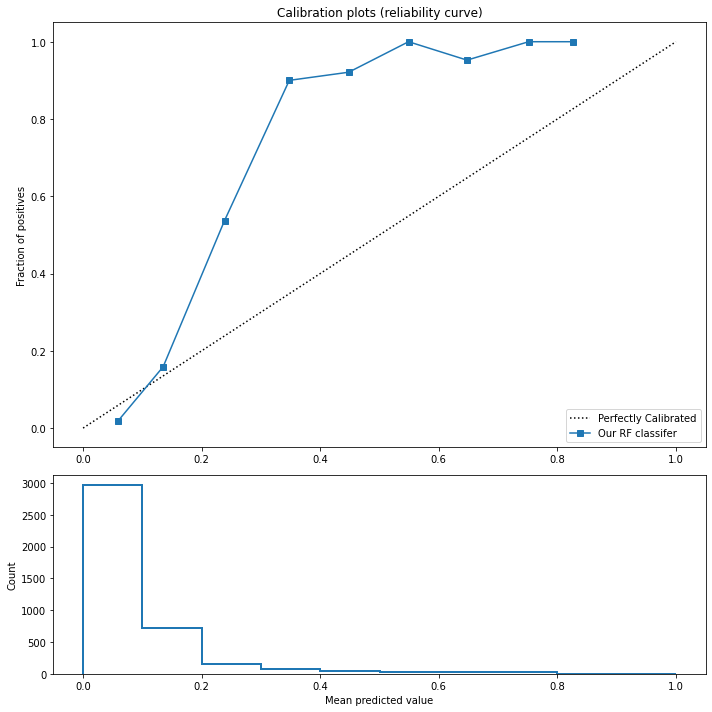

In [13]:
# check our calibrating
from sklearn.calibration import calibration_curve

fig = plt.figure(figsize = (10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan = 2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], 'k:', label = 'Perfectly Calibrated')

fraction_of_positives, mean_predicted_value = calibration_curve(y_true = predictions['y_test'],
                                                               y_prob = predictions['y_test_pred'],
                                                               n_bins = 10)

ax1.plot(mean_predicted_value, fraction_of_positives, 's-', label = 'Our RF classifer')
ax2.hist(predictions['y_test_pred'], range = (0, 1), bins = 10, histtype = 'step', lw = 2)

ax1.set_ylabel('Fraction of positives')
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc='lower right')
ax1.set_title('Calibration plots (reliability curve)')

ax2.set_xlabel('Mean predicted value')
ax2.set_ylabel('Count')

plt.tight_layout()

Calibration is OK, but not perfect - let's skip the calibration step here.<br>
To use the predicted churn probability, we simply need to replace all 1/0 churn values with it in all calculations.

In [14]:
# taking churn into account
predictions['basecase_revenue_after_churn'] = predictions['basecase_revenue'] * (1 - 0.919 * predictions['y_test_pred'])

In [15]:
def get_rev_delta(pred: pd.DataFrame, cutoff: float = 0.5, discount: float = 0.2) -> float:
    '''
    Get the delta of revenue for offering discount for all customers with predicted churn risk >= cutoff
    '''
    pred['discount_revenue'] = pred['basecase_revenue_after_churn']
    # Churn predicted => discount is given => customer stays for full year, independent of whether the prediction
    # (false positive, 'free'/unnecessary discount given) or correct
    pred.loc[pred['y_test_pred'] >= cutoff, 'discount_revenue'] = pred['basecase_revenue'] * (1 - discount)
    # save tthe revenue delta for each custtomer in a separate column
    pred['revenue_delta'] = pred['discount_revenue'] - pred['basecase_revenue_after_churn']
    return pred['revenue_delta'].sum()

In [16]:
rev_deltas = pd.Series({cutoff: get_rev_delta(predictions, cutoff = cutoff) for cutoff in np.arange(0, 1, 0.01)})

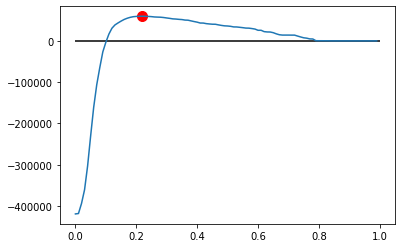

Maximum benefit at cutoff 0.22 with revenue delta of $59,680.30


In [17]:
def plot_tradeoff(rev_deltas: pd.Series):
    # Plot the revenue deltas
    rev_deltas.plot()
    # mark optimal point
    max_pred = rev_deltas.idxmax()
    plt.scatter(max_pred, rev_deltas.loc[max_pred], s = 100, c = 'red')
    # Reference line for break-even
    plt.hlines(0, 0, 1)
    plt.show()
    print(f'Maximum benefit at cutoff {max_pred} with revenue delta of ${rev_deltas.loc[max_pred]:,.2f}')

plot_tradeoff(rev_deltas)